### Import Data and Set Parameters

In [2]:
# Import Modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import os
import json

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Set Pathes
DATA_IN_PATH = './txt_sim/'
DATA_OUT_PATH = './txt_sim/data_out/'
TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
# Set Parameters
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [5]:
# Load Files
q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
# Hyper Parameters
model_name = 'cnn_similarity'
BATCH_SIZE = 64
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = 31

kargs = {'model_name':model_name,
         'vocab_size':prepro_configs['vocab_size'],
         'word_embedding_dimension':100,
         'conv_num_filters':300,
         'conv_window_size':3,
         'max_pool_seq_len':MAX_LEN,
         'sent_embedding_dimension':128,
         'dropout_rate':0.2,
         'hidden_dimension':200,
         'output_dimension':1}

#### Model Implementation

In [7]:
class SentenceEmbedding(layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()
        
        self.conv = layers.Conv1D(kargs['conv_num_filters'], kargs['conv_window_size'],
                                  activation=tf.keras.activations.relu,
                                  padding='same')
        self.max_pool = layers.MaxPool1D(kargs['max_pool_seq_len'], 1)
        self.dense = layers.Dense(kargs['sent_embedding_dimension'],
                                  activation=tf.keras.activations.relu)
    
    def call(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.dense(x)
        
        return tf.squeeze(x, 1)

In [10]:
class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super(SentenceSimilarityModel, self).__init__(name=kargs['model_name'])
        
        self.word_embedding = layers.Embedding(kargs['vocab_size'], kwargs['word_embedding_dimension'])
        self.base_encoder = SentenceEmbedding(**kargs)
        self.hypo_encoder = SentenceEmbedding(**kargs)
        self.dense = layers.Dense(kargs['hidden_dimension'],
                                  activation=tf.keras.activations.relu)
        self.logit = layers.Dense(1, activation=tf.keras.activations.sigmoid)
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        
    def call(self, x):
        x1, x2 = x
        b_x = self.word_embedding(x1)
        h_x = self.word_embedding(x2)
        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)
        
        b_x = self.base_encoder(b_x)
        h_x = self.hypo_encoder(h_x)
        
        e_x = tf.concat([b_x, h_x], -1)
        e_x = self.dense(e_x)
        e_x = self.dropout(e_x)
        
        return self.logit(e_x)

#### Model Complile

In [11]:
model = SentenceSimilarityModel(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy(name='accuracy'))

#### EarlyStopping

In [12]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./txt_sim/data_out/cnn_similarity -- Folder create complete 



#### Model Training

In [13]:
history = model.fit((q1_data, q2_data), labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/100
4199/4199 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.7392
Epoch 1: val_accuracy improved from -inf to 0.75550, saving model to ./txt_sim/data_out/cnn_similarity\weights.h5
4199/4199 [==============================] - 371s 88ms/step - loss: 0.5218 - accuracy: 0.7392 - val_loss: 0.4977 - val_accuracy: 0.7555
Epoch 2/100
4199/4199 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8069
Epoch 2: val_accuracy improved from 0.75550 to 0.80923, saving model to ./txt_sim/data_out/cnn_similarity\weights.h5
4199/4199 [==============================] - 367s 87ms/step - loss: 0.4152 - accuracy: 0.8069 - val_loss: 0.4146 - val_accuracy: 0.8092
Epoch 3/100
4199/4199 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8538
Epoch 3: val_accuracy did not improve from 0.80923
4199/4199 [==============================] - 370s 88ms/step - loss: 0.3292 - accuracy: 0.8538 - val_loss: 0.6044 - val_accuracy: 0.7491


#### Performance Graph

In [14]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

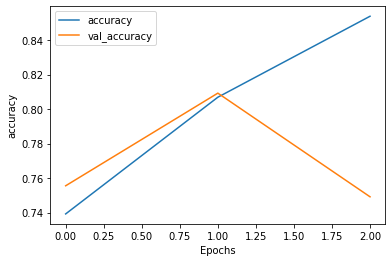

In [15]:
plot_graphs(history, 'accuracy')

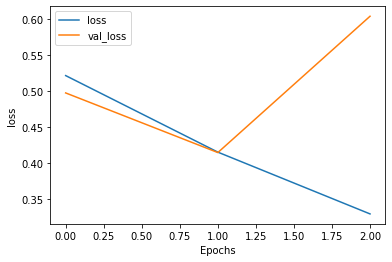

In [16]:
plot_graphs(history, 'loss')

#### Load Test Data and Best Model

In [17]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [18]:
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

#### Prediction

In [19]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

36654/36654 [==============================] - 139s 4ms/step


In [20]:
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv(DATA_OUT_PATH +'cnn_predict.csv', index=False, quoting=3)